In [3]:
import math
import numpy as np
from matplotlib import pyplot as plt
import scipy.constants as constants
import scipy.optimize as opt

In [4]:
def Himmelblau_2D(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def nonsmooth_Himmelblau_2D(x, y):
    return np.abs(x**2 + y - 11) + np.abs(x + y**2 - 7)

def gradient_2D(x, y):
    dfdx = 2 * (x**2 + y - 11) * 2*x + 2 * (x + y**2 - 7)
    dfdy = 2 * (x**2 + y - 11) + 2 * (x + y**2 - 7) * 2*y
    return dfdx, dfdy

def Himmelblau(vec):
    x, y = vec
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def Himmelblau_gradient(vec):
    x, y = vec
    dfdx = 2 * (x**2 + y - 11) * 2*x + 2 * (x + y**2 - 7)
    dfdy = 2 * (x**2 + y - 11) + 2 * (x + y**2 - 7) * 2*y
    return np.array([dfdx, dfdy])

def Himmelblau_hessian(vec):
    x, y = vec
    H00 = 12*x**2 + 4*y - 42
    H01 = 4*x + 4*y
    H10 = H01
    H11 = 4*x + 12*y**2 - 26
    return np.array([[H00, H01],
                     [H10, H11]])

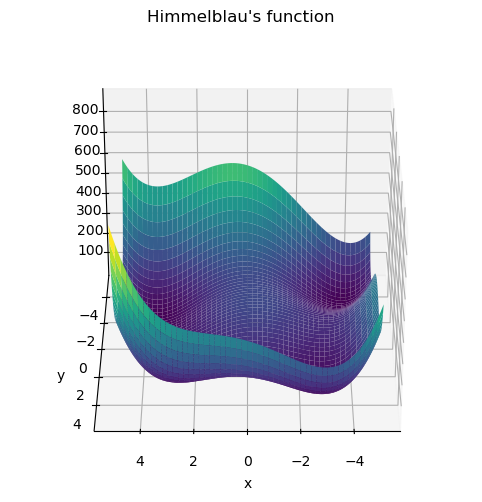

In [5]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)

Z = Himmelblau_2D(X, Y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z, cmap="viridis")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Himmelblau's function")
ax.view_init(elev=30, azim=90)
plt.show()

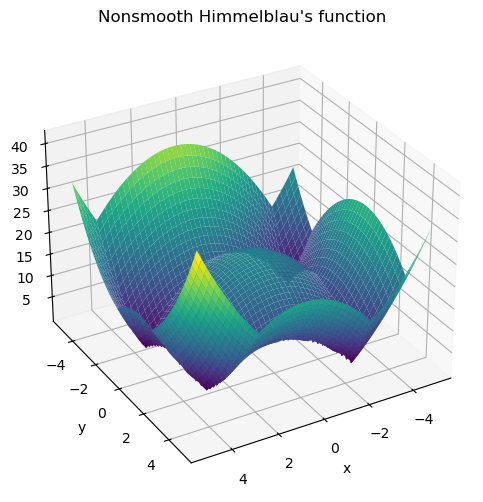

In [287]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)

Z = nonsmooth_Himmelblau_2D(X, Y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z, cmap="viridis")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Nonsmooth Himmelblau's function")
ax.view_init(elev=30, azim=60)
plt.show()

## Demo 1: BFGS on smooth Himmelblau's Function

and comparison to simple gradient descent and Newton's method

Disclaimer: the line_search step with zoom structure was borrowed from chapter 4 of Mathematical Optimization: https://indrag49.github.io/Numerical-Optimization/

Note: I realized that treating two variables became really hard to track due to repetitive names. I changed the function such that it takes in a single vector in the form of [x, y]

In [7]:
def line_search(f, grad, x, p, c1=1e-4, c2=0.9, alpha_init=1.0):
    alpha0 = 0
    alpha1 = alpha_init
    phi0 = f(x)
    dphi0 = np.dot(grad(x), p)
    
    phi_start = phi0
    
    counter = 0
    while(True):
        phi_alpha = f(x + alpha1 * p)
        g_alpha = grad(x + alpha1 * p)
        dphi_alpha = np.dot(g_alpha, p)
        
        if (phi_alpha > phi0 + c1 * alpha1 * dphi0) or (alpha0 > 0 and phi_alpha > phi_start):
            return zoom(f, grad, x, p, c1, c2, alpha_lo=alpha0, alpha_hi=alpha1, phi0=phi0, dphi0=dphi0)
        
        if dphi_alpha >= c2 * dphi0:
            return alpha1
        
        if dphi_alpha > 0:
            return zoom(f, grad, x, p, c1, c2, alpha_lo=alpha1, alpha_hi=alpha0, phi0=phi0, dphi0=dphi0)
        
        alpha0 = alpha1
        phi_prev = phi_alpha
        alpha1 *= 2.0
        counter += 1
        
        if counter >= 20:
            return alpha1

        
def zoom(f, grad, x, p, c1, c2, alpha_lo, alpha_hi, phi0, dphi0):
    # basically a bisection for alpha
    tolerance = 1e-9
    
    counter = 0
    while(True):
        alpha_mid = 0.5 * (alpha_lo + alpha_hi)
        
        if abs(alpha_hi - alpha_lo) < tolerance:
            return alpha_mid
        
        phi_amid  = f(x + alpha_mid * p)
        phi_alo = f(x + alpha_lo * p)
        g_amid = grad(x + alpha_mid * p)
        dphi_amid = np.dot(g_amid, p)

        if (phi_amid > phi0 + c1 * alpha_mid * dphi0) or (phi_amid >= phi_alo):
            alpha_hi = alpha_mid
        else:
            if dphi_amid >= c2 * dphi0:
                return alpha_mid
            
            if dphi_amid * (alpha_hi - alpha_lo) >= 0:
                alpha_hi = alpha_lo

            alpha_lo = alpha_mid
            
        counter += 1
        
        if counter >= 20:
            return alpha_mid

In [375]:
vec = [3, 2]
vector = np.array(vec)
vector += np.array([1, 1])
vec

[3, 2]

In [417]:
def bfgs(f, grad, x_init, tol=1e-12):
    xs = []
    x = np.array(x_init)
    H = np.identity(2)
    
    while(True):
        xs.append(x)
        grad_norm = np.linalg.norm(grad(x))
        
        if grad_norm < tol:
            return x, f(x), np.array(xs)
        
        g = grad(x)
        p = np.dot(-H, g)
        
        if np.dot(g, p) >= 0:
            p = -g
        
        alpha = line_search(f, grad, x, p)
        
        s = alpha * p
        x_new = x + s
        grad_new = grad(x_new)
        y = grad_new - g
        
        ys = np.dot(y, s)
        if ys > 1e-10:
            rho = 1.0 / ys
            I = np.identity(2)
            V = I - rho * np.outer(s, y)
            H = V.dot(H).dot(V.T) + rho * np.outer(s, s)
            
        x = x_new

In [475]:
def newton(f, grad, hess, x_init, tol=1e-12):
    xs = []
    x = np.array(x_init)
    
    while(True):
        xs.append(x)
        g = grad(x)
        if np.linalg.norm(g) < tol:
            return x, f(x), np.array(xs)

        H = hess(x)

        step = np.linalg.solve(H, -g)
        x = x + step

In [464]:
def gradient_descent(f, grad, x_init, alpha=0.001, tol=1e-8):
    xs = []
    x = np.array(x_init)
    
    while(True):
        xs.append(x)
        g = grad(x)
        if np.linalg.norm(g) < tol:
            return x, f(x), np.array(xs)
        
        x_new = x - alpha * g
        
        x = x_new

I apologize for the bad naming conventions here. x_i are supposed to be the starting points of each run. xi is supposed to record the calculated minium of a function. I ran into an issue where Newton's method starts at an already optimized point, then realized that it was due to x_i and xi previously having the same name.

In [476]:
x_0 = [4.3, 3]
x, minimum, history = bfgs(Himmelblau, Himmelblau_gradient, x_0)
x_newton, minimum_newton, history_newton = newton(Himmelblau, Himmelblau_gradient, Himmelblau_hessian, x_0)
x_gd, minimum_gd, history_gd = gradient_descent(Himmelblau, Himmelblau_gradient, x_0)

In [477]:
x_1 = [4.2, 3]
x1, minimum1, history1 = bfgs(Himmelblau, Himmelblau_gradient, x_1)
x_newton1, minimum_newton1, history_newton1 = newton(Himmelblau, Himmelblau_gradient, Himmelblau_hessian, x_1)

In [478]:
x_2 = [4, 3]
x2, minimum2, history2 = bfgs(Himmelblau, Himmelblau_gradient, x_2)
x_newton2, minimum_newton2, history_newton2 = newton(Himmelblau, Himmelblau_gradient, Himmelblau_hessian, x_2)

In [479]:
x_3 = [1, -1]
x3, minimum3, history3 = bfgs(Himmelblau, Himmelblau_gradient, x_3)
x_newton3, minimum_newton3, history_newton3 = newton(Himmelblau, Himmelblau_gradient, Himmelblau_hessian, x_3)

In [480]:
x_4 = [2, 0]
x4, minimum4, history4 = bfgs(Himmelblau, Himmelblau_gradient, x_4)
x_newton4, minimum_newton4, history_newton4 = newton(Himmelblau, Himmelblau_gradient, Himmelblau_hessian, x_4)

In [481]:
history_newton

array([[4.3       , 3.        ],
       [3.40194858, 2.29075707],
       [3.05861144, 2.03324663],
       [3.00167182, 2.00020747],
       [3.00000156, 1.99999932],
       [3.        , 2.        ],
       [3.        , 2.        ]])

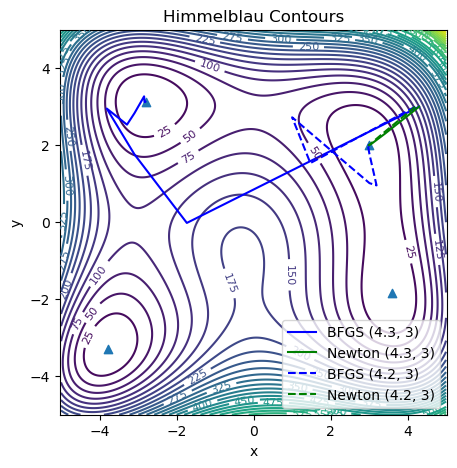

In [482]:
x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
X, Y = np.meshgrid(x, y)

Z = Himmelblau_2D(X, Y)

plt.figure(figsize=(5, 5))

contours = plt.contour(X, Y, Z, levels=40)
plt.clabel(contours, inline=True, fontsize=8)

plt.title('Himmelblau Contours')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

zeros = np.array([[3, -2.805118, -3.779310, 3.584428], [2, 3.131312, -3.283186, -1.848126]])

plt.plot(history[:, 0], history[:, 1], c='b', label='BFGS (4.3, 3)')
plt.plot(history_newton[:, 0], history_newton[:, 1], c='g', label='Newton (4.3, 3)')
#plt.plot(history_gd[:, 0], history_gd[:, 1], label='Gradient Descent')

plt.plot(history1[:, 0], history1[:, 1], c='b', label='BFGS (4.2, 3)', ls='--')
plt.plot(history_newton1[:, 0], history_newton1[:, 1], c='g', label='Newton (4.2, 3)', ls='--')
#plt.plot(history_gd[:, 0], history_gd[:, 1], label='Gradient Descent')

#plt.plot(history3[:, 0], history3[:, 1], c='b', label='BFGS (1, 3)', ls=':')
#plt.plot(history_newton3[:, 0], history_newton3[:, 1], c='g', label='Newton (1, 3)', ls=':')

#plt.plot(history4[:, 0], history4[:, 1], c='b', label='BFGS (2, 3)', ls='-.')
#plt.plot(history_newton4[:, 0], history_newton4[:, 1], c='g', label='Newton (2, 3)', ls='-.')

plt.legend()
plt.scatter(zeros[0, :], zeros[1, :], marker='^', label='Global minima')

In [483]:
def convergence(f, history):
    function_values = []
    for point in history:
        function_values.append(f(point))
    return np.array(function_values)

In [276]:
bfgs_conv  = convergence(Himmelblau, history)
newton_conv = convergence(Himmelblau, history_newton)
#gd_conv = convergence(Himmelblau, history_gd)

In [277]:
bfgs_conv1  = convergence(Himmelblau, history1)
newton_conv1 = convergence(Himmelblau, history_newton1)

In [278]:
bfgs_conv2  = convergence(Himmelblau, history2)
newton_conv2 = convergence(Himmelblau, history_newton2)

In [279]:
bfgs_conv3  = convergence(Himmelblau, history3)
newton_conv3 = convergence(Himmelblau, history_newton3)

In [280]:
bfgs_conv4  = convergence(Himmelblau, history4)
newton_conv4 = convergence(Himmelblau, history_newton4)

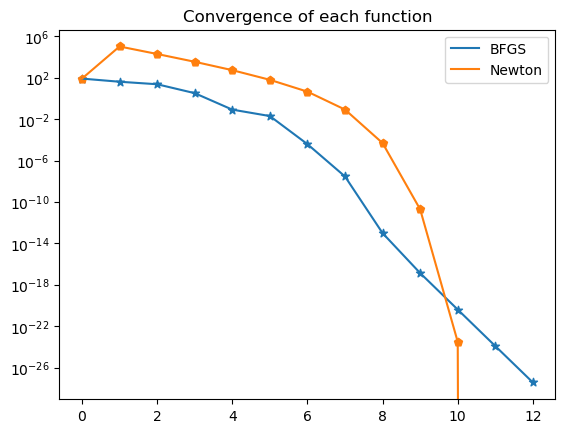

In [167]:
plt.plot(np.arange(bfgs_conv.size), bfgs_conv, label='BFGS')
plt.scatter(np.arange(bfgs_conv.size), bfgs_conv, marker='*')
plt.plot(np.arange(newton_conv.size), newton_conv, label='Newton')
plt.scatter(np.arange(newton_conv.size), newton_conv, marker='p')
#plt.plot(gd_conv, label='Gradient Descent')
plt.yscale('log')
plt.title('Convergence of each function')
plt.legend()

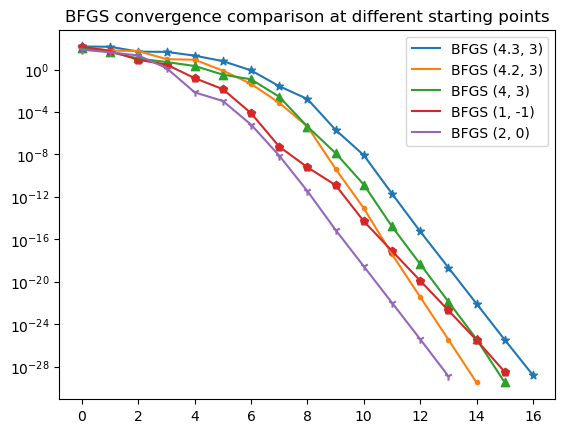

In [281]:
plt.plot(np.arange(bfgs_conv.size), bfgs_conv, label='BFGS (4.3, 3)')
plt.scatter(np.arange(bfgs_conv.size), bfgs_conv, marker='*')
plt.plot(np.arange(bfgs_conv1.size), bfgs_conv1, label='BFGS (4.2, 3)')
plt.scatter(np.arange(bfgs_conv1.size), bfgs_conv1, marker='.')
plt.plot(np.arange(bfgs_conv2.size), bfgs_conv2, label='BFGS (4, 3)')
plt.scatter(np.arange(bfgs_conv2.size), bfgs_conv2, marker='^')
plt.plot(np.arange(bfgs_conv3.size), bfgs_conv3, label='BFGS (1, -1)')
plt.scatter(np.arange(bfgs_conv3.size), bfgs_conv3, marker='p')
plt.plot(np.arange(bfgs_conv4.size), bfgs_conv4, label='BFGS (2, 0)')
plt.scatter(np.arange(bfgs_conv4.size), bfgs_conv4, marker='1')
#plt.plot(gd_conv, label='Gradient Descent')
plt.yscale('log')
plt.title('BFGS convergence comparison at different starting points')
plt.legend()

## Rosenbrock function

This function only has one minimum at (1, 1)

In [16]:
def Rosenbrock_2D(x, y):
    return (1 - x)**2 + (y - x**2)**2

def Rosenbrock(vec):
    x, y = vec
    return (1 - x)**2 + (y - x**2)**2

def Rosenbrock_gradient(vec):
    x, y = vec
    dfdx = -2*(1-x) - 4*(y - x**2)
    dfdy = 2*(y - x**2)
    return np.array([dfdx, dfdy])

def Rosenbrock_hessian(vec):
    x, y = vec
    H00 = 2 - 4*y + 12*x**2
    H10 = -4*x
    H01 = -4*x
    H11 = 2
    return np.array([[H00, H01],
                     [H10, H11]])

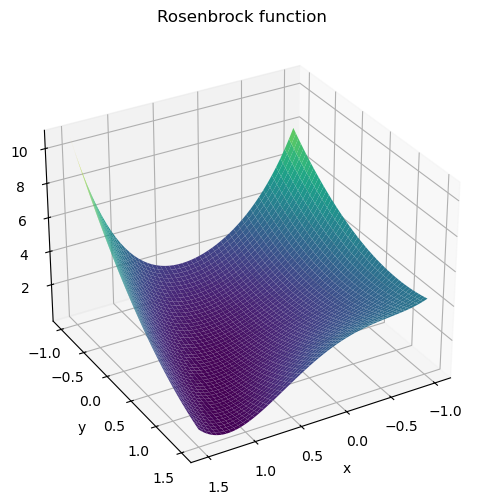

In [222]:
x = np.linspace(-1, 1.5, 1000)
y = np.linspace(-1, 1.5, 1000)
X, Y = np.meshgrid(x, y)

Z = Rosenbrock_2D(X, Y)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z, cmap="viridis")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Rosenbrock function")
ax.view_init(elev=30, azim=60)
plt.show()

In [515]:
x0 = [1.2, -0.5]
x, minimum, history = bfgs(Rosenbrock, Rosenbrock_gradient, x0)
x_newton, minimum_newton, history_newton = newton(Rosenbrock, Rosenbrock_gradient, Rosenbrock_hessian, x0)
x_gd, minimum_gd, history_gd = gradient_descent(Rosenbrock, Rosenbrock_gradient, x0)

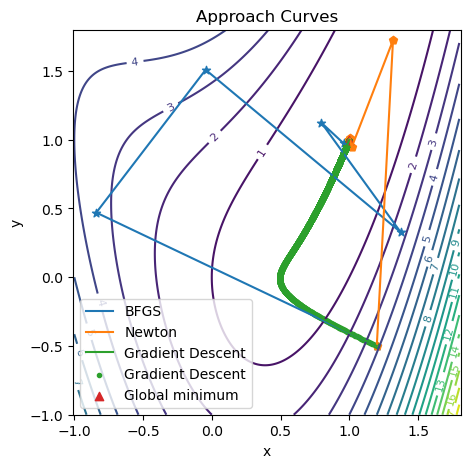

In [516]:
x = np.linspace(-1, 1.8, 400)
y = np.linspace(-1, 1.8, 400)
X, Y = np.meshgrid(x, y)

Z = Rosenbrock_2D(X, Y)

plt.figure(figsize=(5, 5))

contours = plt.contour(X, Y, Z, levels=20)
plt.clabel(contours, inline=True, fontsize=8)

plt.title('Approach Curves')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
#plt.scatter(1, 1, marker='^', label='Global minimum')

plt.plot(history[:, 0], history[:, 1], label='BFGS')
plt.scatter(history[:, 0], history[:, 1], marker='*')
plt.plot(history_newton[:, 0], history_newton[:, 1], label='Newton')
plt.scatter(history_newton[:, 0], history_newton[:, 1], marker='p')
plt.plot(history_gd[:, 0], history_gd[:, 1], label='Gradient Descent')
plt.scatter(history_gd[:, 0], history_gd[:, 1], marker='.', label='Gradient Descent')
plt.scatter(1, 1, marker='^', label='Global minimum')
plt.legend()

In [517]:
bfgs_conv  = convergence(Rosenbrock, history)
newton_conv = convergence(Rosenbrock, history_newton)
gd_conv = convergence(Rosenbrock, history_gd)

Comment out different convergence lines for different demos. If gradient descent is commented out, it shows comparison between Newton and BFGS. If Newton is commented out, it shows how slow GD is. gd = gradient descent.

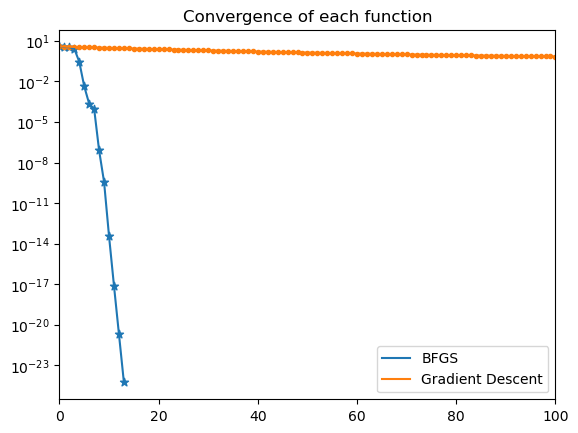

In [518]:
plt.plot(np.arange(bfgs_conv.size), bfgs_conv, label='BFGS')
plt.scatter(np.arange(bfgs_conv.size), bfgs_conv, marker='*')
#plt.plot(np.arange(newton_conv.size), newton_conv, label='Newton')
#plt.scatter(np.arange(newton_conv.size), newton_conv, marker='p')
plt.plot(gd_conv, label='Gradient Descent')
plt.scatter(np.arange(gd_conv.size), gd_conv, marker='.')
plt.yscale('log')
plt.xlim(left=0, right=100)
plt.title('Convergence of each function')
plt.legend()

## Nonsmooth Himmelblau Function

This function replaces the squares, and instead have "kinks" along certain lines.

In [520]:
def Himmelblau_2D(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def nonsmooth_Himmelblau_2D(x, y):
    return np.abs(x**2 + y - 11) + np.abs(x + y**2 - 7)

def gradient_2D(x, y):
    dfdx = 2 * (x**2 + y - 11) * 2*x + 2 * (x + y**2 - 7)
    dfdy = 2 * (x**2 + y - 11) + 2 * (x + y**2 - 7) * 2*y
    return dfdx, dfdy

def nonsmooth_Himmelblau(vec):
    x, y = vec
    return np.abs(x**2 + y - 11) + np.abs(x + y**2 - 7)

def nonsmooth_Himmelblau_gradient(vec):
    x, y = vec
    
    g1 = x**2 + y - 11
    g2 = x + y**2 - 7

    s1 = np.sign(g1)
    s2 = np.sign(g2)

    df_dx = 2*x*s1 + s2
    df_dy = s1 + 2*y*s2

    return np.array([df_dx, df_dy])

def nonsmooth_Himmelblau_hessian(vec):
    x, y = vec
    
    g1 = x**2 + y - 11
    g2 = x + y**2 - 7

    s1 = np.sign(g1)
    s2 = np.sign(g2)
    
    H00 = 2*s1
    H01 = 0
    H10 = 0
    H11 = 2*s2
    return np.array([[H00, H01],
                     [H10, H11]])

In [521]:
x_0 = [2.5, 3]
x, minimum, history = bfgs(nonsmooth_Himmelblau, nonsmooth_Himmelblau_gradient, x_0)
x_newton, minimum_newton, history_newton = newton(nonsmooth_Himmelblau, nonsmooth_Himmelblau_gradient, nonsmooth_Himmelblau_hessian, x_0)
#x_gd, minimum_gd, history_gd = gradient_descent(nonsmooth_Himmelblau, nonsmooth_Himmelblau_gradient, x0)

In [522]:
x_1 = [2.5, -2]
x1, minimum1, history1 = bfgs(nonsmooth_Himmelblau, nonsmooth_Himmelblau_gradient, x_1)
x_newton1, minimum_newton1, history_newton1 = newton(nonsmooth_Himmelblau, nonsmooth_Himmelblau_gradient, nonsmooth_Himmelblau_hessian, x_1)

In [523]:
x_2 = [-4, -1]
x2, minimum2, history2 = bfgs(nonsmooth_Himmelblau, nonsmooth_Himmelblau_gradient, x_2)
x_newton2, minimum_newton2, history_newton2 = newton(nonsmooth_Himmelblau, nonsmooth_Himmelblau_gradient, nonsmooth_Himmelblau_hessian, x_2)

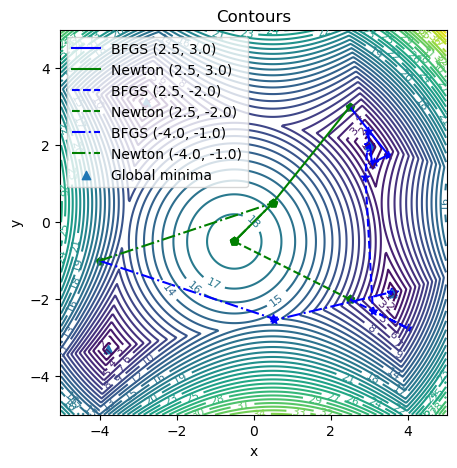

In [524]:
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)

Z = nonsmooth_Himmelblau_2D(X, Y)

plt.figure(figsize=(5, 5))

contours = plt.contour(X, Y, Z, levels=50)
plt.clabel(contours, inline=True, fontsize=8)

plt.title('Contours')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')

plt.plot(history[:, 0], history[:, 1], c='b', label='BFGS (2.5, 3.0)')
plt.scatter(history[:, 0], history[:, 1], c='b', marker='*')
plt.plot(history_newton[:, 0], history_newton[:, 1], c='g', label='Newton (2.5, 3.0)')
plt.scatter(history_newton[:, 0], history_newton[:, 1], c='g', marker='p')

plt.plot(history1[:, 0], history1[:, 1], c='b', label='BFGS (2.5, -2.0)', ls='--')
plt.scatter(history1[:, 0], history1[:, 1], c='b', marker='*')
plt.plot(history_newton1[:, 0], history_newton1[:, 1], c='g', label='Newton (2.5, -2.0)', ls='--')
plt.scatter(history_newton1[:, 0], history_newton1[:, 1], c='g', marker='p')

plt.plot(history2[:, 0], history2[:, 1], c='b', label='BFGS (-4.0, -1.0)', ls='-.')
plt.scatter(history2[:, 0], history2[:, 1], c='b', marker='*')
plt.plot(history_newton2[:, 0], history_newton2[:, 1], c='g', label='Newton (-4.0, -1.0)', ls='-.')
plt.scatter(history_newton2[:, 0], history_newton2[:, 1], c='g', marker='p')
#plt.plot(history_gd[:, 0], history_gd[:, 1], label='Gradient Descent')

plt.scatter(zeros[0, :], zeros[1, :], marker='^', label='Global minima')
plt.legend()

In [525]:
bfgs_conv  = convergence(nonsmooth_Himmelblau, history)
newton_conv = convergence(nonsmooth_Himmelblau, history_newton)

bfgs_conv1  = convergence(nonsmooth_Himmelblau, history1)
newton_conv1 = convergence(nonsmooth_Himmelblau, history_newton1)

bfgs_conv2  = convergence(nonsmooth_Himmelblau, history2)
newton_conv2 = convergence(nonsmooth_Himmelblau, history_newton2)

Both BFGS and Newton's convergence here. I commented out differnt methods because of coloring.

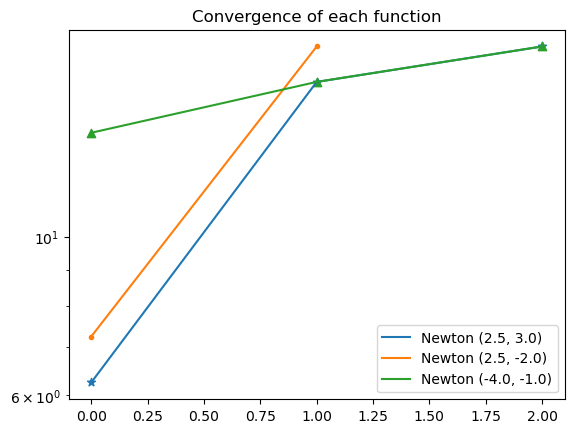

In [530]:
#plt.plot(np.arange(bfgs_conv.size), bfgs_conv, label='BFGS (2.5, 3.0)')
#plt.scatter(np.arange(bfgs_conv.size), bfgs_conv, marker='*')
plt.plot(np.arange(newton_conv.size), newton_conv, label='Newton (2.5, 3.0)')
plt.scatter(np.arange(newton_conv.size), newton_conv, marker='*')

#plt.plot(np.arange(bfgs_conv1.size), bfgs_conv1,  label='BFGS (2.5, -2.0)')
#plt.scatter(np.arange(bfgs_conv1.size), bfgs_conv1, marker='.')
plt.plot(np.arange(newton_conv1.size), newton_conv1, label='Newton (2.5, -2.0)')
plt.scatter(np.arange(newton_conv1.size), newton_conv1, marker='.')

#plt.plot(np.arange(bfgs_conv2.size), bfgs_conv2, label='BFGS (-4.0, -1.0)')
#plt.scatter(np.arange(bfgs_conv2.size), bfgs_conv2,  marker='^')
plt.plot(np.arange(newton_conv2.size), newton_conv2, label='Newton (-4.0, -1.0)')
plt.scatter(np.arange(newton_conv2.size), newton_conv2, marker='^')

#plt.plot(gd_conv, label='Gradient Descent')
plt.yscale('log')
plt.title('Convergence of each function')
plt.legend()

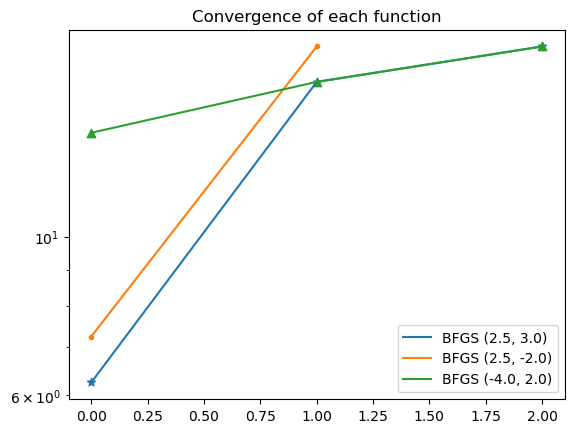

In [508]:
plt.plot(np.arange(newton_conv.size), newton_conv, label='Newton (2.5, 3.0)')
plt.scatter(np.arange(newton_conv.size), newton_conv, marker='*')
plt.plot(np.arange(newton_conv1.size), newton_conv1, label='Newton (2.5, -2.0)')
plt.scatter(np.arange(newton_conv1.size), newton_conv1, marker='.')
plt.plot(np.arange(newton_conv2.size), newton_conv2, label='Newton (-4.0, 2.0)')
plt.scatter(np.arange(newton_conv2.size), newton_conv2, marker='^')

#plt.plot(gd_conv, label='Gradient Descent')
plt.yscale('log')
plt.title('Convergence of each function')
plt.legend()

## Ackley Function

This guy has a bunch of local minima and only one global minimum

In [27]:
def ackley_2D(x, y, a=20, b=0.2, c=2*np.pi):
    return -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(c * x) + np.cos(c * y))) + np.e + a

def ackley(vec, a=20, b=0.2, c=2*np.pi):
    x, y = vec
    return -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(c * x) + np.cos(c * y))) + np.e + a

def ackley_grad(vec, a=20, b=0.2, c=2*np.pi):
    x, y = vec
    u = np.sqrt(0.5 * (x**2 + y**2))

    if u == 0.0:
        grad_T1_x = 0.0
        grad_T1_y = 0.0
    else:
        E1 = np.exp(-b * u)
        common = a * b * E1 / (2.0 * u)  # ab e^{-bu} / (2u)
        grad_T1_x = common * x
        grad_T1_y = common * y

    # Second term: T2 = -exp( (cos(cx) + cos(cy))/2 )
    # dT2/dx =  (c/2) sin(cx) * exp( (cos(cx) + cos(cy))/2 )
    # dT2/dy =  (c/2) sin(cy) * exp( (cos(cx) + cos(cy))/2 )
    E2 = np.exp(0.5 * (np.cos(c*x) + np.cos(c*y)))
    grad_T2_x = 0.5 * c * np.sin(c * x) * E2
    grad_T2_y = 0.5 * c * np.sin(c * y) * E2

    return np.array([grad_T1_x + grad_T2_x,
                     grad_T1_y + grad_T2_y])